# Plots for `Madam Iqra` 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_grouped_bars_double_x(
    df,
    species=None,
    temps_order=None,
    times_order=None,
    value_col="Germination_%",
    se_col="SE",
    figsize=(10, 5),
    bar_group_width=0.8,
    cmap="tab10",
    title=None
):
    """
    Grouped bar plot where the primary grouping is Temperature (top axis),
    and within each temperature there are bars for each incubation time (bottom labels).
    Optionally filter by `species` (string or list). Expects a tidy DataFrame with columns:
      - 'Species' (optional, used when species provided),
      - 'Temperature_C' (categorical / numeric grouping for top axis),
      - 'Incubation_h' (categorical for bottom labels),
      - value_col (e.g., 'Germination_%'),
      - se_col (e.g., 'SE').

    Behavior:
      - Bottom x-axis: one tick per bar showing incubation time (e.g., "2 h"),
        repeated for each temperature group.
      - Top x-axis: one tick centered above each temperature group showing the temperature.
      - Bars for different incubation times use different colors and a shared legend.

    Returns the matplotlib Figure and Axes objects.
    """
    df_plot = df.copy()

    # Filter by species if provided
    if species is not None:
        if isinstance(species, (list, tuple, set)):
            df_plot = df_plot[df_plot["Species"].isin(species)]
        else:
            df_plot = df_plot[df_plot["Species"] == species]

    if df_plot.shape[0] == 0:
        raise ValueError("No data available for the requested filter (check 'species' or column names).")

    # Determine unique temperatures and times ordering
    if temps_order is None:
        temps = sorted(df_plot["Temperature_C"].unique())
    else:
        temps = list(temps_order)
    if times_order is None:
        times = sorted(df_plot["Incubation_h"].unique())
    else:
        times = list(times_order)

    n_temps = len(temps)
    n_times = len(times)

    # Build matrix of values and SEs: rows = temperatures, cols = times
    val_matrix = np.zeros((n_temps, n_times))
    se_matrix = np.zeros((n_temps, n_times))

    for i, temp in enumerate(temps):
        for j, t in enumerate(times):
            row = df_plot[(df_plot["Temperature_C"] == temp) & (df_plot["Incubation_h"] == t)]
            if len(row) == 0:
                val = 0.0
                se = 0.0
            else:
                # If multiple rows (shouldn't be), take mean
                val = row[value_col].mean()
                se = row[se_col].mean() if se_col in df_plot.columns else 0.0
            val_matrix[i, j] = val
            se_matrix[i, j] = se

    # Calculate bar positions
    group_centers = np.arange(n_temps)  # 0,1,2,... for each temperature group
    width = bar_group_width / n_times
    # For each time index j, positions = group_centers + offset
    offsets = (np.arange(n_times) - (n_times - 1) / 2.0) * width

    fig, ax = plt.subplots(figsize=figsize)

    # Colors
    cmap_vals = plt.get_cmap(cmap)
    colors = [cmap_vals(i) for i in np.linspace(0, 1, n_times)]

    # Plot bars (one series per incubation time)
    for j, t in enumerate(times):
        positions = group_centers + offsets[j]
        ax.bar(
            positions,
            val_matrix[:, j],
            width=width * 0.95,
            color=colors[j],
            label=f"{t} h",
            yerr=se_matrix[:, j] if se_col in df_plot.columns else None,
            capsize=3
        )

    # Build bottom ticks grouped by temperature (left-to-right)
    positions_matrix = (group_centers.reshape(-1, 1) + offsets.reshape(1, -1))
    bottom_ticks = positions_matrix.flatten()
    bottom_labels = []
    for temp in temps:
        for t in times:
            bottom_labels.append(f"{t} h")

    ax.set_xticks(bottom_ticks)
    ax.set_xticklabels(bottom_labels, rotation=45, ha="right", fontsize=9)

    # Top axis: temperature labels centered above groups
    ax_top = ax.twiny()
    # align twinned axis: set limits equal
    ax.set_xlim(group_centers[0] - 0.5, group_centers[-1] + 0.5)
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(group_centers)
    ax_top.set_xticklabels([str(int(x)) for x in temps], fontsize=10)  # temperature numbers
    ax_top.set_xlabel("Temperature (°C)")

    ax.set_ylabel(value_col.replace("_", " "))
    if title:
        ax.set_title(title)

    # Grid & legend
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="Incubation time", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    # Show explicitly so notebooks render output when this function is executed
    try:
        plt.show()
    except Exception:
        pass

    return fig, ax

# ---------------------------
# Example usage (with your existing df)
# ---------------------------
# fig, ax = plot_grouped_bars_double_x(df, species="Pa. chlamydospora", title="Pa. chlamydospora Germination")
# (The function calls plt.show() internally, so calling it will render the plot in the notebook.)


Saved dummy data to: d:\04 L1 Python_Ka_Chila\Data_Science_Ammar\Madam_Iqra\germination_dummy.csv


C:\Users\mirza\AppData\Local\Temp\ipykernel_25184\2216724284.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])  # leave space at bottom for legend_ax


Saved figure to: d:\04 L1 Python_Ka_Chila\Data_Science_Ammar\Madam_Iqra\germination_grouped_plot_by_temp.png


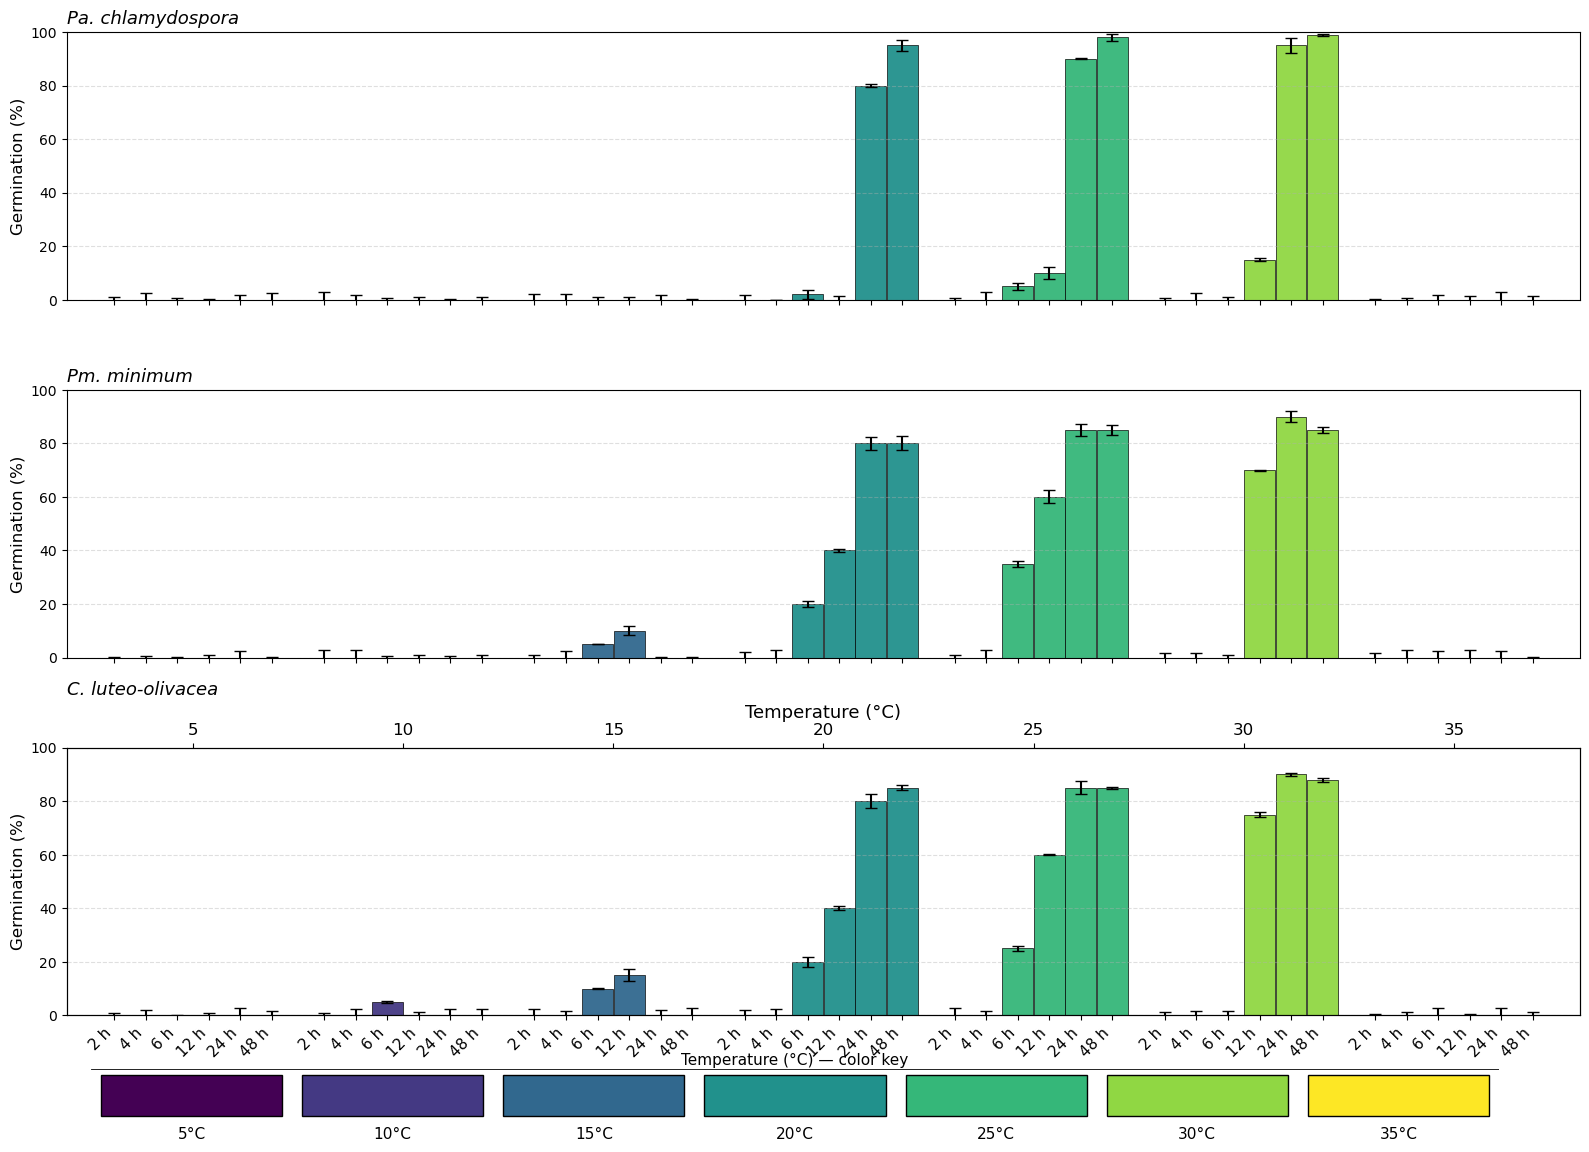

In [ ]:
# Create dummy germination data, export CSV, and plot grouped bars (one subplot per species)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

# Experiment parameters: reduce temps to 7 values (removed the highest temp 40)
species_list = ["Pa. chlamydospora", "Pm. minimum", "C. luteo-olivacea"]
temps = np.array([5, 10, 15, 20, 25, 30, 35])  # 7 temperature groups
times = [2, 4, 6, 12, 24, 48]

# Dummy germination matrices (rows=times, cols=temps) - adjust arrays to match 7 temps
Pa_chlamydospora = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,2,5,0,0],
    [0,0,0,0,10,15,0],
    [0,0,0,80,90,95,0],
    [0,0,0,95,98,99,0]
])
Pm_minimum = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,5,20,35,0,0],
    [0,0,10,40,60,70,0],
    [0,0,0,80,85,90,0],
    [0,0,0,80,85,85,0]
])
C_luteo_olivacea = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,5,10,20,25,0,0],
    [0,0,15,40,60,75,0],
    [0,0,0,80,85,90,0],
    [0,0,0,85,85,88,0]
])

data_dict = {
    "Pa. chlamydospora": Pa_chlamydospora,
    "Pm. minimum": Pm_minimum,
    "C. luteo-olivacea": C_luteo_olivacea
}

# Dummy SEs
np.random.seed(42)
errors = {sp: np.random.rand(*arr.shape) * 3 for sp, arr in data_dict.items()}

# Convert to long (tidy) DataFrame
records = []
for sp, arr in data_dict.items():
    for i, t in enumerate(times):
        for j, temp in enumerate(temps):
            records.append({
                "Species": sp,
                "Incubation_h": t,
                "Temperature_C": temp,
                "Germination_%": float(arr[i, j]),
                "SE": float(errors[sp][i, j])
            })

df = pd.DataFrame(records)

# Save CSV next to the notebook
out_path = Path.cwd() / "germination_dummy.csv"
df.to_csv(out_path, index=False)
print(f"Saved dummy data to: {out_path}")

# ----------------- Plot: 1 row per species, grouped bars per temperature -----------------
# We'll color by temperature (one color per temperature group)
n_temps = len(temps)
n_times = len(times)

group_centers = np.arange(n_temps)
bar_group_width = 0.9
width = bar_group_width / n_times
offsets = (np.arange(n_times) - (n_times - 1) / 2.0) * width

fig, axes = plt.subplots(len(species_list), 1, figsize=(16, 12), sharex=True, sharey=True)
if len(species_list) == 1:
    axes = [axes]

# Color palette based on temperature groups
cmap = plt.get_cmap('viridis')
temp_colors = [cmap(i) for i in np.linspace(0, 1, n_temps)]

for ax, sp in zip(axes, species_list):
    subset = df[df['Species'] == sp]
    # build matrices rows=temp, cols=times
    val_matrix = np.zeros((n_temps, n_times))
    se_matrix = np.zeros((n_temps, n_times))
    for i, temp in enumerate(temps):
        for j, t in enumerate(times):
            row = subset[(subset['Temperature_C'] == temp) & (subset['Incubation_h'] == t)]
            if len(row) == 0:
                val = 0.0
                se = 0.0
            else:
                val = row['Germination_%'].mean()
                se = row['SE'].mean() if 'SE' in subset.columns else 0.0
            val_matrix[i, j] = val
            se_matrix[i, j] = se

    # Plot by temperature so all bars at the same temperature share the same color
    for i, temp in enumerate(temps):
        for j, t in enumerate(times):
            pos = group_centers[i] + offsets[j]
            ax.bar(
                pos,
                val_matrix[i, j],
                width=width * 0.98,
                color=temp_colors[i],
                label=None,
                yerr=se_matrix[i, j],
                capsize=4,
                edgecolor='black',
                linewidth=0.5,
                alpha=0.95
            )

    ax.set_ylim(0, 100)
    ax.set_ylabel('Germination (%)', fontsize=12)
    ax.set_title(sp, loc='left', fontstyle='italic', fontsize=13)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# Bottom ticks: one tick per bar, grouped by temperature
positions_matrix = (group_centers.reshape(-1, 1) + offsets.reshape(1, -1))
bottom_ticks = positions_matrix.flatten()
bottom_labels = [f"{t} h" for _ in range(n_temps) for t in times]

axes[-1].set_xticks(bottom_ticks)
axes[-1].set_xticklabels(bottom_labels, rotation=45, ha='right', fontsize=11)

# Top axis for temperature labels centered above groups (use bottom axes[-1] to create shared top axis)
ax_top = axes[-1].twiny()
axes[-1].set_xlim(group_centers[0] - 0.6, group_centers[-1] + 0.6)
ax_top.set_xlim(axes[-1].get_xlim())
ax_top.set_xticks(group_centers)
ax_top.set_xticklabels([str(int(x)) for x in temps], fontsize=12)
ax_top.set_xlabel('Temperature (°C)', fontsize=13)

# Create a horizontal color-box legend under the x-axis mapping colors to temperatures
legend_ax = fig.add_axes([0.06, 0.02, 0.88, 0.045])  # left, bottom, width, height (figure coords)
legend_ax.set_xlim(-0.5, n_temps - 0.5)
legend_ax.set_ylim(0, 1)
legend_ax.axis('off')

box_w = 0.9
for i, temp in enumerate(temps):
    rect = patches.Rectangle((i - box_w/2, 0.12), box_w, 0.76, facecolor=temp_colors[i], edgecolor='black')
    legend_ax.add_patch(rect)
    legend_ax.text(i, -0.08, f"{int(temp)}°C", ha='center', va='top', fontsize=11)

# Thin separating line above the legend boxes
legend_ax.plot([-0.5, n_temps - 0.5], [0.99, 0.99], color='black', linewidth=0.6)

# Add caption-like label centered above the colored boxes
legend_ax.text(n_temps/2 - 0.5, 0.99 + 0.03, 'Temperature (°C) — color key', ha='center', va='bottom', fontsize=11)

plt.tight_layout(rect=[0, 0.06, 1, 0.96])  # leave space at bottom for legend_ax

# Save figure (higher resolution)
fig_path = Path.cwd() / 'germination_grouped_plot_by_temp.png'
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {fig_path}")

plt.show()